# OCR (Optical Character Recognition)
- Text Detection + Text Recognition
  - Text detection
    - 문자의 영역을 검출
    - object detection 기법과 segmentation 기법을 활용
    - 문자가 가지는 독특한 특성까지 고려
  - Text recognition
    - 문자를 인식

## [Tesseract OCR](https://github.com/tesseract-ocr/tesseract)

구현할 모델 구조  
- Text detector: Segmentation기반의 [CRAFT](http://arxiv.org/pdf/1904.01941) 활용한 keras-ocr
- Text recognition

### Dataset for OCR
- 데이터셋에 필요한 텍스트 정보를 사람이 직접 입력해야 함
- 데이터 문제를 해결하기 위한 방법 중 하나로는 컴퓨터로 대량 문자 이미지 데이터를 만들어내는 방법
- 직접 문자 데이터를 생성하게 되면, 원하는 언어를 원하는 폰트와 원하는 배치 및 크기로 문자 이미지를 대량으로 만들어낼 수 있음

- 논문에서 비교하기 위해 많이 사용하는 데이터셋
  - [MJSynth](http://www.robots.ox.ac.uk/~vgg/data/text/)
  - [SynthText](https://www.robots.ox.ac.uk/~vgg/data/scenetext/)

In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


### Recognition model
![rcnn](https://d3s0tskafalll9.cloudfront.net/media/original_images/e-23-2.crnn.png)  
- CRNN의 구조는 위 그림에서 아래부터 올라가는 순서  
![arch](https://d3s0tskafalll9.cloudfront.net/media/original_images/e-23-3.crnn_structure.png)  
- 입력이미지를 Convolution Layer를 통해 Feature를 추출하여 추출된 Feature를 얻음
-  **Recurrent Layer**는 추출된 Feature의 전체적인 Context를 파악하고 다양한 output의 크기에 대응이 가능
- **Transcription layer(Fully connected layer)**는 step마다 어떤 character의 확률이 높은지 예측

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [3]:
!pip install lmdb

In [4]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


### 1) Input image

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


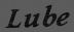

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


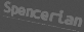

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


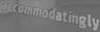

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


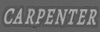

In [5]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH,
                max_readers=32,
                readonly=True,
                lock=False,
                readahead=False,
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))

        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)
        print('target_img_size:{}'.format(target_img_size))
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

- lmdb를 활용하여 케라스 모델 학습용 MJSynth데이터셋 클래스를 구현
  - `dataset_path`는 읽어들일 데이터셋의 경로
  - `label_converter`는 문자를 미리 정의된 index로 변환해주는 converter로 직접 구현
  - `batch_size`와 입력이미지 크기 그리고 필터링을 위한 최대 글자 수, 학습대상으로 한정하기 위한 character등을 입력

In [6]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self,
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :

        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]


    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)

    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size

            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)

    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    #
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)

        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

- `_get_img_label()`
  - 이미지 데이터를 img, label의 쌍으로 가져옴
  - 이미지를 모두 height는 32로 맞추고, width는 최대 100까지로 맞춤
- `model.fit()`에서 호출되는 `__getitem__()` 메소드에서 배치 단위만큼 `_get_img_label()` 를 통해 가져온 데이터셋을 리턴

### 2) Encode
- Label이 우리가 읽을 수 있는 평문 Text : 모델을 학습하기 위해서 적절한 형태가 아님
- 각 Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode를 해주어야 함

In [7]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

- `__init__()`
  - 입력으로 받은 `text`를 `self.dict`에 각 character들이 어떤 index에 매핑되는지 저장
  - 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어  짐
  - 만약 character='ABCD'라면 'A'의 label은 1, 'B'의 label은 2가 됨
- 공백(blank) 문자를 지정
  - 여기서는 공백 문자를 뜻하기 위해 `'-'`를 활용, label은 `0`으로 지정
- `decode()`
  - 각 index를 다시 character로 변환한 후 이어주어 우리가 읽을 수 있는 text로 바꿈

In [8]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


### 3) Build CRNN model

In [9]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

- Keras에서 제공하는 `K.ctc_batch_cost()`를 활용해서 loss를 계산

**[K.ctc_batch_cost()](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/backend/ctc_batch_cost)**  
![ctc](https://d3s0tskafalll9.cloudfront.net/media/original_images/ctc.png)  
- 입력의 길이 T와 라벨의 길이 U의 단위가 일치하지 않을 때 사용
- 만약 모델이 AAAPPPPLLLLEE을 출력, 그럼 어떻게 APLE일지 APPLE일지 구분함?
  - 추론 결과가 APPLE이 되게 하려면 이미지의 라벨은 AP-PLE로 보정해 주어야 함
  - 모델이 AAAPP-PPLLLEE로 출력을 한다면 추론 결과는 APPLE이 되는 것
  - 이런 이유로 `LabelConverter.encode()` 메소드에 공백문자 처리 로직을 포함
- `y_true`: tensor (samples, max_string_length) containing the truth labels.
  - 실제 라벨 **LUBE**
  - 텍스트 라벨 그대로가 아니라, 각 글자를 **One-hot 인코딩**한 형태
- `y_pred`: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
  - **RCNN 모델의 출력 결과**
  - 길이는 4가 아니라 우리가 만들 **RNN의 최종 출력 길이**
- `input_length` tensor: (samples, 1) containing the sequence length for each batch item in y_pred.
  - 모델 입력 길이 `T`
  - 텍스트 이미지의 width인 74
- `label_length` tensor: (samples, 1) containing the sequence length for each batch item in y_true.
  - 라벨의 실제 정답 길이 `U`
  - LUBE 라벨인 경우 4
- `samples` : batch size

In [10]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')

    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

### 4) Train & Inference

In [11]:
# 데이터셋과 모델
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델 컴파일
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(
    loss={'ctc': lambda y_true, y_pred: y_pred},
    optimizer=optimizer,
    metrics=['accuracy'],
)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_path = HOME_DIR + '/model_checkpoint_accuracy.hdf5'

earlystop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
ckp = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=20,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop]
)

Epoch 1/20
565/565 [==============================] - 97s 149ms/step - loss: 25.8027 - accuracy: 0.0000e+00 - val_loss: 25.1089 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 25.10890, saving model to /aiffel/aiffel/ocr/model_checkpoint_accuracy.hdf5
Epoch 2/20
565/565 [==============================] - 84s 148ms/step - loss: 17.7615 - accuracy: 4.1482e-05 - val_loss: 11.3107 - val_accuracy: 6.2004e-04

Epoch 00002: val_loss improved from 25.10890 to 11.31069, saving model to /aiffel/aiffel/ocr/model_checkpoint_accuracy.hdf5
Epoch 3/20
565/565 [==============================] - 84s 148ms/step - loss: 8.2415 - accuracy: 0.0390 - val_loss: 7.0918 - val_accuracy: 0.0627

Epoch 00003: val_loss improved from 11.31069 to 7.09183, saving model to /aiffel/aiffel/ocr/model_checkpoint_accuracy.hdf5
Epoch 4/20
565/565 [==============================] - 83s 147ms/step - loss: 5.6820 - accuracy: 0.1809 - val_loss: 5.5784 - val_accuracy: 0.2225

Epoch 00004: val_loss improved

In [13]:
import matplotlib.pyplot as plt

def visualize_history(history, title):
    plt.figure(figsize=(12, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

In [14]:
import pandas as pd

def save_history_to_csv_path(history, csv_path):
    history_data = history.history
    df = pd.DataFrame(history_data)
    df.to_csv(csv_path, index=False)

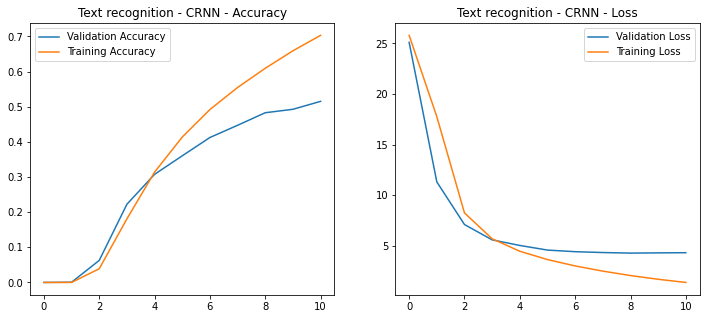

In [16]:
visualize_history(history, "Text recognition - CRNN")

- Loss는 수렴이 되는 것 같아 보이는데 아직 accuracy는 학습할 여지가 많이 남아있는 것 같음
- 일단 좋은 모델이 아니라고 했으니 성능 개선은 스킵 ㅎㅎ

In [17]:
csv_path = HOME_DIR + '/crnn_history_accuracy.csv'
save_history_to_csv_path(history, csv_path)

In [18]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/model_checkpoint_accuracy.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING


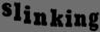

Result: 	 ALEPPO


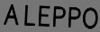

Result: 	 FWENDE


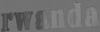

Result: 	 NATHANS


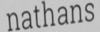

Result: 	 HALEO


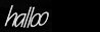

Result: 	 HURTS


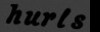

Result: 	 DOWNSIZE


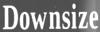

Result: 	 ROBOTIC


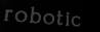

Result: 	 SLOPPY


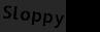

Result: 	 HERMITE


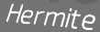

['SLINKING',
 'ALEPPO',
 'FWENDE',
 'NATHANS',
 'HALEO',
 'HURTS',
 'DOWNSIZE',
 'ROBOTIC',
 'SLOPPY',
 'HERMITE']

In [19]:
from IPython.display import display

def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=True , beam_width=1, top_paths=1
        )[0][0]
    )[0]
    # print("Decoded Indexes:", indexes)
    indexes = [idx for idx in indexes if idx != -1]
    
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

def check_inference(model, dataset, index=5):
    result_list = []
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        result_list.append(result)
        
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))
        
    return result_list

check_inference(model_pred, test_set, index=10)

In [20]:
test_i, test_o = test_set[0]
decoded_labels = [label_converter.decode(label) for label in test_i['label']]
print(decoded_labels)

['SLINKING--------------', 'REMODELERS------------', 'CHRONOGRAPHS----------', 'IMPEACHING------------', 'DISCOMBOBULATED-------', 'LO-OTS----------------', 'UNDERPAYS-------------', 'FLAMEPRO-OFED---------', 'ENTICEMENTS-----------', 'UKASE-----------------', 'DESCANTED-------------', 'CO-OLIDGE-------------', 'DOZINES-S-------------', 'DELIBERATIONS---------', 'SUPREMACY-------------', 'REMODELERS------------', 'RESOLED---------------', 'PERCIPIENCE-----------', 'TER-RIFYINGLY---------', 'PRIZEWIN-NER----------', 'ELABORATELY-----------', 'HOPSCOTCHED-----------', 'TELNET-TED------------', 'DISPROPORTIONAL-------', 'WARMING---------------', 'BO-OKSTORES-----------', 'METER-----------------', 'SAVAGENES-S-----------', 'POP-PADOMS------------', 'GUISES----------------', 'TBS-------------------', 'RECEPTACLE------------', 'MAS-------------------', 'GLADIOLI--------------', 'GUNSHIPS--------------', 'COXES-----------------', 'DOZY------------------', 'EMPOWERED-------------', 'PUZ-ZLERS-

In [21]:
def check_inference_all(model, dataset):
    num_of_dataset = len(dataset)
    result_list = check_inference(model, dataset, index=num_of_dataset)
    return result_list

Result: 	 SLINKING


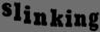

Result: 	 ALEPPO


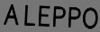

Result: 	 FWENDE


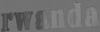

Result: 	 NATHANS


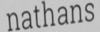

Result: 	 HALEO


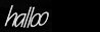

Result: 	 HURTS


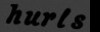

Result: 	 DOWNSIZE


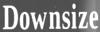

Result: 	 ROBOTIC


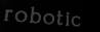

Result: 	 SLOPPY


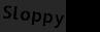

Result: 	 HERMITE


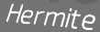

Result: 	 DEARS


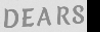

Result: 	 POLYSYLLABIC


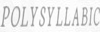

Result: 	 DERETE


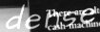

Result: 	 DIAERESES


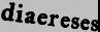

Result: 	 HUMPBACKS


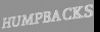

Result: 	 MDOPTEDD


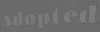

Result: 	 MILWAUKEE


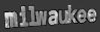

Result: 	 SPECIFICATION


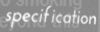

Result: 	 REACIONARY


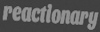

Result: 	 OSCEOLA


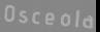

Result: 	 DWORES


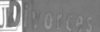

Result: 	 DQNED


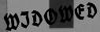

Result: 	 BEECHNUT


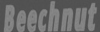

Result: 	 POLYGLOTS


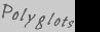

Result: 	 LUNGODLIER


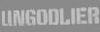

Result: 	 ATAVIST


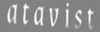

Result: 	 IDTERUS


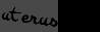

Result: 	 ATFMED


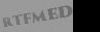

Result: 	 ARDUOUS


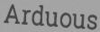

Result: 	 SZLUTTR


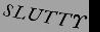

Result: 	 MOL


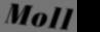

Result: 	 BENEDICTION


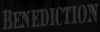

Result: 	 BLUEPRINT


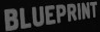

Result: 	 INICKNAMED


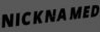

Result: 	 DISINTEGRATION


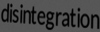

Result: 	 VOICELESSNESS


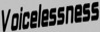

Result: 	 GEPEGSRS


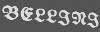

Result: 	 CLICES


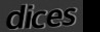

Result: 	 EMIRATES


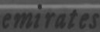

Result: 	 POPULATIONS


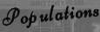

Result: 	 REVIVIFY


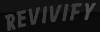

Result: 	 PUSSIEST


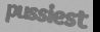

Result: 	 CUTAWAYS


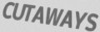

Result: 	 JAPE


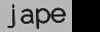

Result: 	 ENUMERATES


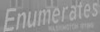

Result: 	 THEODORA


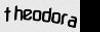

Result: 	 HOUISEEREAKING


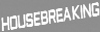

Result: 	 TAMPA


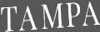

Result: 	 SALTED


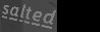

Result: 	 TEQILAS


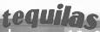

Result: 	 ROULETTE


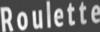

Result: 	 SAMBUEA


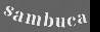

Result: 	 ACRUNG


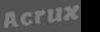

Result: 	 MUNITIONING


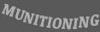

Result: 	 PENCILED


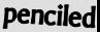

Result: 	 HEDONIST


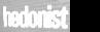

Result: 	 INTERLARDING


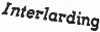

Result: 	 PECULETES


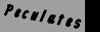

Result: 	 RONGM


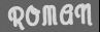

Result: 	 RFEMONSTRONCES


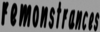

Result: 	 TELESGAPE


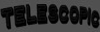

Result: 	 LOUNGING


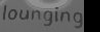

Result: 	 TROULNZS


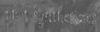

Result: 	 GSRIS


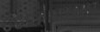

Result: 	 FISK


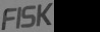

Result: 	 DEFBAT


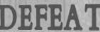

Result: 	 BOTHERATION


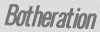

Result: 	 BRIOCHES


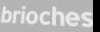

Result: 	 SMELLY


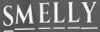

Result: 	 ETHOLOGICAL


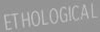

In [22]:
result_list = check_inference_all(model_pred, test_set)

In [ ]:
def get_labels_from_dataset_path(dataset_path, num_of_samples=0):
    env = lmdb.open(dataset_path,
                    max_readers=32,
                    readonly=True,
                    lock=False,
                    readahead=False,
                    meminit=False)
    
    labels = []
    with env.begin(write=False) as txn:
        if num_of_samples == None:
            num_of_samples = int(txn.get('num-samples'.encode()))
        
        for index in range(1, num_of_samples+1):
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            labels.append(label)
            
    return labels

In [24]:
num_of_samples = len(result_list)
original_labels = get_labels_from_dataset_path(TEST_DATA_PATH, num_of_samples=num_of_samples)
original_labels

['slinking',
 'REMODELERS',
 'Chronographs',
 'Impeaching',
 'discombobulated',
 'Loots',
 'underpays',
 'flameproofed',
 'ENTICEMENTS',
 'Ukase',
 'DESCANTED',
 'Coolidge',
 'DOZINESS',
 'deliberations',
 'supremacy',
 'remodelers',
 'RESOLED',
 'Percipience',
 'Terrifyingly',
 'prizewinner',
 'elaborately',
 'Hopscotched',
 'Telnetted',
 'Disproportional',
 'WARMING',
 'Bookstores',
 'Meter',
 'SAVAGENESS',
 'poppadoms',
 'guises',
 'TBS',
 'Receptacle',
 'Mas',
 'gladioli',
 'gunships',
 'COXES',
 'dozy',
 'empowered',
 'PUZZLERS',
 'DESIGNATING',
 'goldmine',
 'Wrist',
 'Prepped',
 'punchy',
 'BELCHING',
 'Tuber',
 'lavatorial',
 'HOSTESSES',
 'bathtub',
 'HALFWAY',
 'Rearm',
 'blather',
 'SCHOOLBOY',
 'TOWNES',
 'ANNOTATING',
 'HISTORIES',
 'glossies',
 'rationalizes',
 'REMASTER',
 'YOURSELF',
 'POT',
 'waffled',
 'DARTH',
 'crestless',
 'finn',
 'Analogies',
 'FATSOS',
 'penises',
 'Domesticates',
 'BREWS']

In [25]:
from Levenshtein import distance as levenshtein_distance

def calculate_performance(predictions, ground_truth):
    assert len(predictions) == len(ground_truth), f"predictions len: {len(predictions)}, ground_truth len: {len(ground_truth)}"
    
    predictions = [p.lower() for p in predictions]
    ground_truth = [g.lower() for g in ground_truth]

    # WER
    wer = sum([p == g for p, g in zip(predictions, ground_truth)]) / len(ground_truth)
    print(f"Word Accuracy: {wer:.2%}")
    
    # Levenshtein Distance
    lev_distances = [levenshtein_distance(p, g) for p, g in zip(predictions, ground_truth)]
    avg_lev_distance = sum(lev_distances) / len(ground_truth)
    print(f"Average Levenshtein Distance: {avg_lev_distance:.2f}")
    
    # CER
    total_chars = sum(len(g) for g in ground_truth)
    cer = sum(lev_distances) / total_chars
    print(f"Character Error Rate (CER): {cer:.2%}")

In [26]:
calculate_performance(result_list, original_labels)

Word Accuracy: 1.43%
Average Levenshtein Distance: 7.96
Character Error Rate (CER): 96.37%


- 대소문자 구분없이 비교를 했지만, 완전히 인식한 결과는 약 1퍼센트밖에 되지 않음
- 대부분의 단어가 완전히 일치하지는 않지만, 문자 하나 하나 따졌을 때는 약 96퍼센트의 CER 값을 가짐
- [일단 detector도 같이 해보자..](./0305_ocr_impl.ipynb)